## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>

Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import median_absolute_error as mae
from sklearn import cluster
from sklearn import feature_selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Прочитаем наш файл с исходными данными:

In [3]:
taxi_data = pd.read_csv('/content/drive/MyDrive/Проектный практикум/train.csv')
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [4]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [5]:
taxi_data['pickup_datetime'].min(), taxi_data['pickup_datetime'].max()

(Timestamp('2016-01-01 00:00:17'), Timestamp('2016-06-30 23:59:39'))

### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [6]:
# Сначала вычисляем кол-во пропусков по стоблцам
for i in taxi_data.columns:
    per_na = taxi_data[taxi_data[i].isna()].shape[0]
    print(f'Кол-во пропусов значений признака {i} -', per_na)

Кол-во пропусов значений признака id - 0
Кол-во пропусов значений признака vendor_id - 0
Кол-во пропусов значений признака pickup_datetime - 0
Кол-во пропусов значений признака dropoff_datetime - 0
Кол-во пропусов значений признака passenger_count - 0
Кол-во пропусов значений признака pickup_longitude - 0
Кол-во пропусов значений признака pickup_latitude - 0
Кол-во пропусов значений признака dropoff_longitude - 0
Кол-во пропусов значений признака dropoff_latitude - 0
Кол-во пропусов значений признака store_and_fwd_flag - 0
Кол-во пропусов значений признака trip_duration - 0


Видим что ни в одном из столбцов пропусков нет, следовательно общее кол-во пропусков = 0

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [7]:
# Пункт А
taxi_data['vendor_id'].value_counts()
# Всего два таксопарка представлено в данных

2    780302
1    678342
Name: vendor_id, dtype: int64

In [8]:
# Пункт Б
taxi_data['passenger_count'].max()
# Девять пассмажиров за один заказ - это максимум

9

In [9]:
# Пункт В
round(taxi_data['trip_duration'].mean()), round(taxi_data['trip_duration'].median())
# Средняя длительность поездки - 959 сек.
# Медианная длительность поездки - 662 сек.

(959, 662)

In [10]:
# Пункт Г
taxi_data['trip_duration'].min(), taxi_data['trip_duration'].max()
# Минимальная длительность поездки - 1 сек.
# Максимальная длительность поездки - 3526282 сек.

(1, 3526282)

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [11]:
# Отдельно реализуем код функции
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df

In [12]:
# применяем функцию к данным
taxi_data = add_datetime_features(taxi_data)

# рассчитываем показатели
saturday_trip = taxi_data['pickup_day_of_week'] == 5
print(taxi_data[saturday_trip].shape[0], 'общее кол-во поездок по субботам')

mean_per_day = taxi_data.shape[0] / taxi_data['pickup_date'].nunique()
print(round(mean_per_day), 'среднее кол-во поездок в день')

220868 общее кол-во поездок по субботам
8015 среднее кол-во поездок в день


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [13]:
holiday_data = pd.read_csv('/content/drive/MyDrive/Проектный практикум/holiday_data.csv', sep=';')
holiday_data.head()

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day


In [14]:
# реализуем функцию отдельно
def add_holiday_features(df_taxi, df_holiday):
    df_taxi['pickup_holiday'] = df_taxi['pickup_date'].apply(
        lambda x: 1 if str(x) in df_holiday['date'].values else 0
    )
    return df_taxi

In [15]:
# применяем к данным
taxi_data = add_holiday_features(taxi_data, holiday_data)

# вычисляем длительность поездки
median_trip_holy = taxi_data['pickup_holiday'] == 1
print('Медианная длительность поезди в праздники:',
      taxi_data[median_trip_holy]['trip_duration'].median())

Медианная длительность поезди в праздники: 585.0


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [16]:
osrm_data = pd.read_csv('/content/drive/MyDrive/Проектный практикум/osrm_data_train.csv')
osrm_data.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [17]:
# реализуем функцию отдельно
def add_osrm_features(df_taxi, df_osrm):
    df_osrm = df_osrm[
        ['id', 'total_distance', 'total_travel_time', 'number_of_steps']
    ]
    return df_taxi.merge(df_osrm, on = 'id', how = 'left')

In [18]:
# добавляем данные
taxi_data = add_osrm_features(taxi_data, osrm_data)

# Пункт А - рассчитываем показатели
median_time_delta = (
    taxi_data['trip_duration'].median()
    - taxi_data['total_travel_time'].median()
)
print('Разница в секундах:', round(median_time_delta))

# Пункт Б
cols_null_count = taxi_data.isnull().sum()
cols_with_null = cols_null_count[cols_null_count > 0]
print('\n', 'Количество пропусков по колонкам:\n', cols_with_null)

# Смотрим что это за строки
null_row = taxi_data['total_distance'].isnull()
display(taxi_data[null_row])

Разница в секундах: 372

 Количество пропусков по колонкам:
 total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
1133561,id3008062,2,2016-06-23 19:04:09,2016-06-23 19:04:35,1,-73.787537,40.64241,-73.787811,40.642109,N,26,2016-06-23,19,3,0,NaN,NaN,NaN


In [19]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [20]:
# реализуем функцию отдельно
def add_geographical_features(df):
    """
    Функция добавляющая в таблицу с данными о поездках:
        - расстояние Хаверсина
        - направление движения

    Args:
        df (DataFrame): исходный набор данных

    Returns:
        df (DataFrame): дополненный набор данных
    """
    df['haversine_distance'] = get_haversine_distance(
        lat1 = df['pickup_latitude'],
        lng1 = df['pickup_longitude'],
        lat2 = df['dropoff_latitude'],
        lng2 = df['dropoff_longitude']
    )
    df['direction'] = get_angle_direction(
        lat1 = df['pickup_latitude'],
        lng1 = df['pickup_longitude'],
        lat2 = df['dropoff_latitude'],
        lng2 = df['dropoff_longitude']
    )
    return df

In [21]:
taxi_data = add_geographical_features(taxi_data)
print('Медианное расстояние Хаверсина:',
    round(taxi_data['haversine_distance'].median(), 2), 'км')

Медианное расстояние Хаверсина: 2.09 км


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [22]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

In [23]:
# реализуем функцию отдельно
def add_cluster_features(df, cluster):
    df['geo_cluster'] = cluster.predict(df[[
        'pickup_latitude',
        'pickup_longitude',
        'dropoff_latitude',
        'dropoff_longitude'
    ]])
    return df

In [24]:
# генерируем новый признак применяя функцию
taxi_data = add_cluster_features(taxi_data, kmeans)

# проверяем получившиеся кластеры
taxi_data['geo_cluster'].value_counts().sort_values(ascending = False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [25]:
weather_data = pd.read_csv('/content/drive/MyDrive/Проектный практикум/weather_data.csv')
weather_data.head()

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast,2015-12-31,3
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast,2015-12-31,4
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast,2015-12-31,5
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast,2015-12-31,6


In [26]:
# реализуем функцию
def add_weather_features(df_taxi, df_weather):
    # извлекаем дату и час, оставляем только нужные данные о погоде
    df_weather['time'] = pd.to_datetime(
        df_weather['time'],
        format = '%Y-%m-%d %H:%M:%S')
    df_weather['date'] = df_weather['time'].dt.date
    df_weather['hour'] = df_weather['time'].dt.hour
    df_weather = df_weather[[
        'temperature',
        'visibility',
        'wind speed',
        'precip',
        'events',
        'date',
        'hour'
    ]]
    # объединяем данные
    df_merged = df_taxi.merge(
        df_weather,
        how = 'left',
        left_on = ['pickup_date', 'pickup_hour'],
        right_on = ['date', 'hour'])
    df_new = df_merged.drop(['date', 'hour'], axis = 1)
    return df_new

In [27]:
# применяем полученную функцию к таблице
taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None


In [28]:
# Пункт А
print(taxi_data[taxi_data['events'] == 'Snow'].shape[0], 'поездок было совершено в снежную погоду')
print('-' * 100)

# Пункт Б
for i in taxi_data.columns:
    per_na = round(taxi_data[taxi_data[i].isna()].shape[0] / taxi_data.shape[0] * 100, 2)
    if per_na > 0:
        print(f'Пропуски значений признака в процентах {i} -', per_na)

13126 поездок было совершено в снежную погоду
----------------------------------------------------------------------------------------------------
Пропуски значений признака в процентах temperature - 0.82
Пропуски значений признака в процентах visibility - 0.82
Пропуски значений признака в процентах wind speed - 0.82
Пропуски значений признака в процентах precip - 0.82
Пропуски значений признака в процентах events - 0.82


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [29]:
# реализуем функцию отдельно
def fill_null_weather_cols(df):
    # заполняем пропуски в столбцах с погодными условиями медианным значением
    weather_cols = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_cols:
        df[col] = df[col].fillna(
            df.groupby('pickup_date')[col].transform('median'))

    # заполняем пропуски в столбце 'events' строкой 'None'
    df['events'] = df['events'].fillna('None')

    # заполняем пропуски в столбцах с информацией из OSRM медианным значением
    values = {'total_distance': df['total_distance'].median(),
        'total_travel_time': df['total_travel_time'].median(),
        'number_of_steps': df['number_of_steps'].median()}

    df = df.fillna(values)
    return df

In [30]:
# применяем созданную функцию к таблице с данными о поездках
taxi_data = fill_null_weather_cols(taxi_data)

print('Медиана в столбце temperature:', round(taxi_data['temperature'].median(), 1))

Медиана в столбце temperature: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


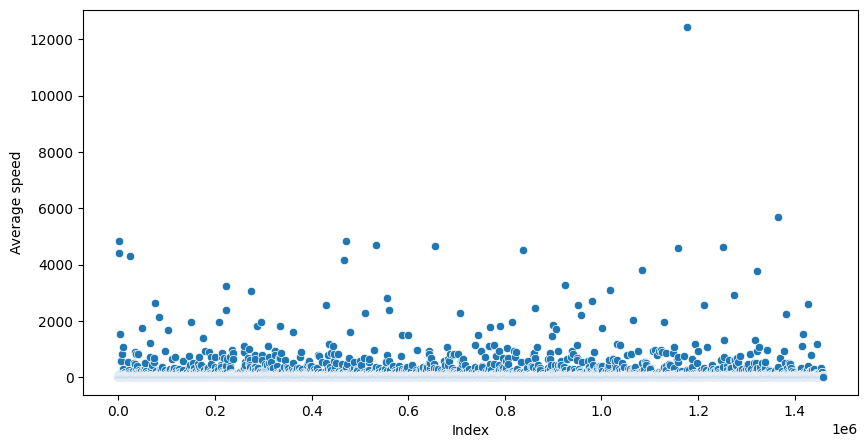

In [31]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [32]:
# Пункт А
# 86400 - кол-во секунд в сутках
print('Количество выбросов по признаку длительности поездки:',
    taxi_data[taxi_data['trip_duration'] > 86400].shape[0])

# Пункт Б
print('Количество выбросов по признаку скорости:',
      avg_speed[avg_speed > 300].shape[0])

mask1 = taxi_data['trip_duration'] <= 86400
mask2 = (taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6) <= 300
taxi_data = taxi_data[mask1 & mask2]

Количество выбросов по признаку длительности поездки: 4
Количество выбросов по признаку скорости: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [33]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

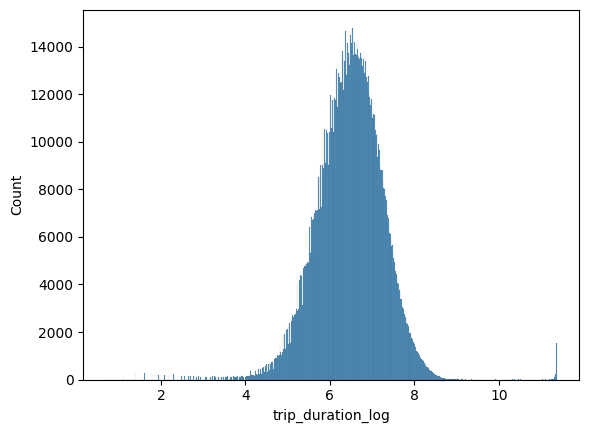

In [34]:
# Строим гистограмму
sns.histplot(x=taxi_data['trip_duration_log'], data=taxi_data['trip_duration_log']);
plt.show()

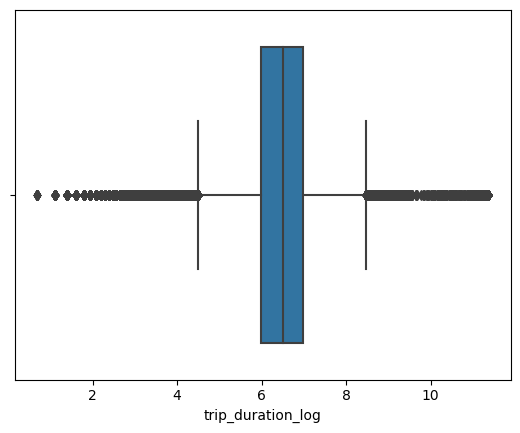

In [35]:
# Строим ящик с усами
sns.boxplot(x=taxi_data['trip_duration_log'], data=taxi_data['trip_duration_log']);
plt.show()

In [36]:
# формируем нулевую и альтернативную гипотезы для проверки данных на нормальность
H0 = 'Данные распределены нормально'
H1 = 'Распределение отлично от нормального'

# устанавливаем уровень значимости
alpha = 0.05

# тест Д'Агостино и Пирсона (возвращает двустороннюю вероятность для проверки гипотезы)
statistic, p_value = stats.normaltest(taxi_data['trip_duration_log'])
print(f'P-value = {round(p_value, 3)}')

if p_value > alpha / 2: # p-value рассчитано для двусторонней гипотезы, поэтому уровень значимости делим на 2
    print(H0)
else:
    print(H1)

P-value = 0.0
Распределение отлично от нормального


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

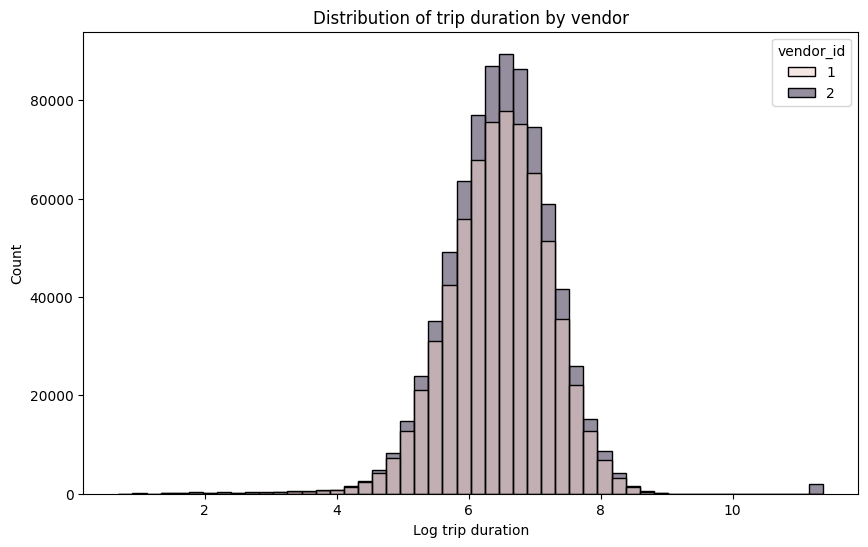

In [37]:
# Гистограмма распределений
plt.figure(figsize=(10, 6))
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', bins=50)
plt.xlabel('Log trip duration')
plt.ylabel('Count')
plt.title('Distribution of trip duration by vendor')
plt.show()

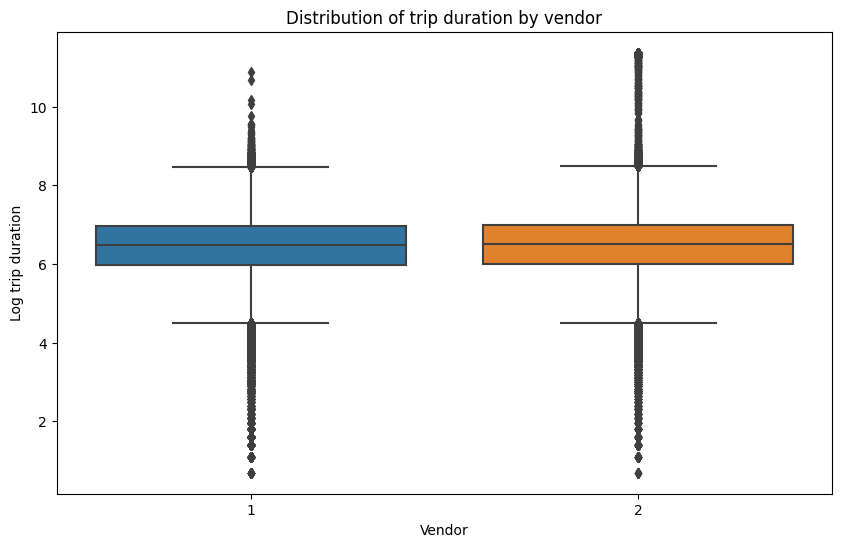

In [38]:
# Боксплот распределений
plt.figure(figsize=(10, 6))
sns.boxplot(data=taxi_data, x='vendor_id', y='trip_duration_log')
plt.xlabel('Vendor')
plt.ylabel('Log trip duration')
plt.title('Distribution of trip duration by vendor')
plt.show()

Распределения в группах визуально не отличаются, а следовательно признак vendor_id не имеет значения при определении длительности поездки.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

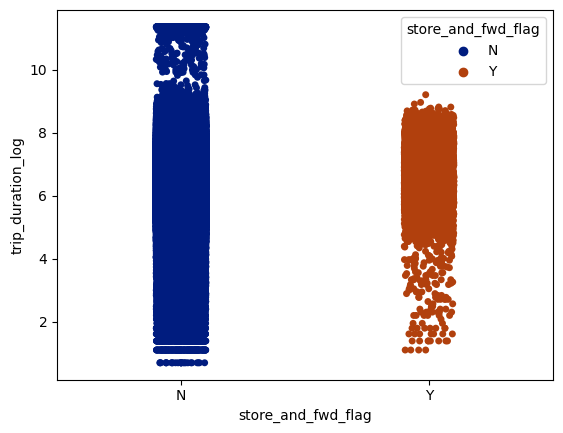

In [39]:
sns.stripplot(x="store_and_fwd_flag", y="trip_duration_log", hue='store_and_fwd_flag', data=taxi_data, palette="dark")
plt.show()

Распределения в группах значительно отличаются, прзнак store_and_fwd_flag имеет значение при определении длительности поездки

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

Text(0.5, 1.0, 'Trip Duration Count by Hour')

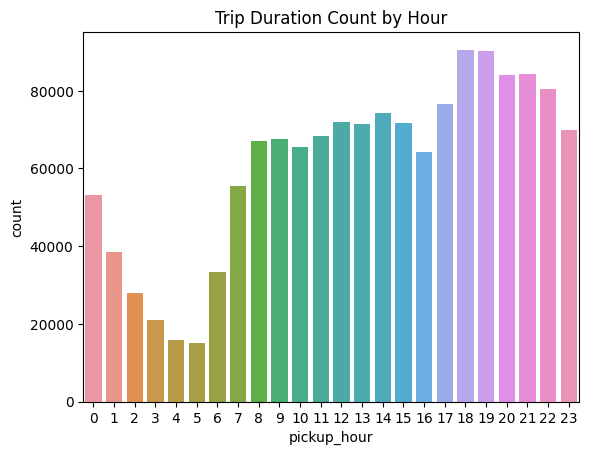

In [40]:
# График №1
countplot = sns.countplot(data = taxi_data, x = 'pickup_hour')
countplot.set_title('Trip Duration Count by Hour')

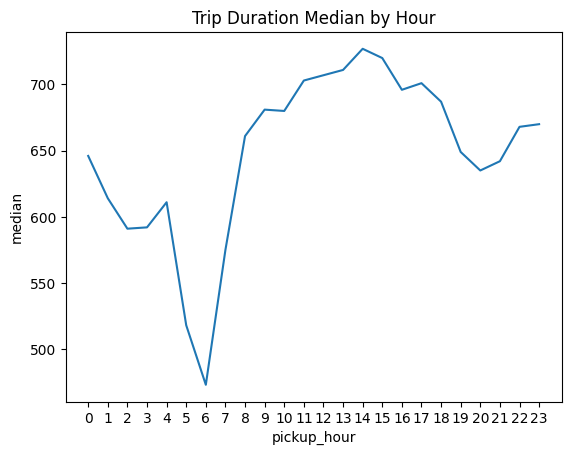

In [41]:
# График №2

# Группируем медианную длительность поездки по часам
trip_duration_by_hour = taxi_data.groupby('pickup_hour')['trip_duration'].median()

lineplot = sns.lineplot(data = trip_duration_by_hour)
lineplot.set_title('Trip Duration Median by Hour')
lineplot.xaxis.set_ticks(trip_duration_by_hour.index)
lineplot.set_ylabel('median');

Пункт А - Реже всего такси заказывают с 00:00 по 5:00.
Пункт Б - Пик медианной длительности поездок наблюдается с 13:00 по 18:00

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


Text(0.5, 1.0, 'Trip Duration Count by Day')

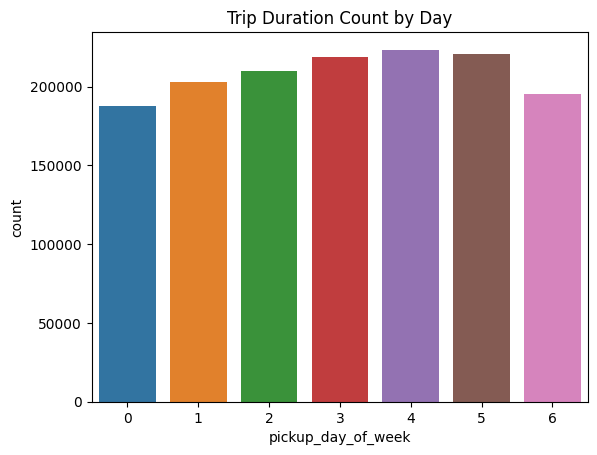

In [42]:
# График №1
countplot = sns.countplot(data = taxi_data, x = 'pickup_day_of_week')
countplot.set_title('Trip Duration Count by Day')

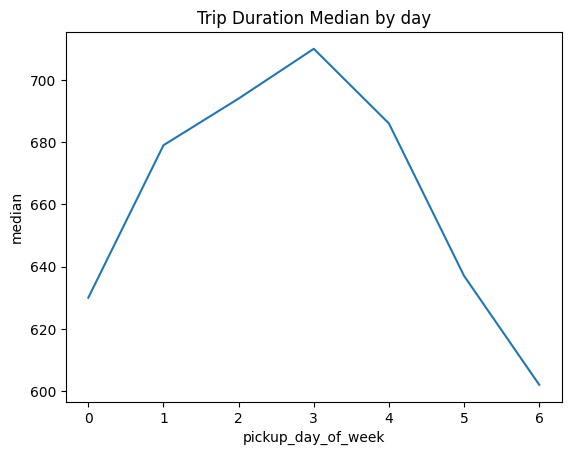

In [43]:
# График №2

# Группируем медианную длительность поездки по дням недели
trip_duration_by_day = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

lineplot = sns.lineplot(data = trip_duration_by_day)
lineplot.set_title('Trip Duration Median by day')
lineplot.xaxis.set_ticks(trip_duration_by_day.index)
lineplot.set_ylabel('median');

Пункт А - в пятницу было совершено больше всего поездок.
Пункт Б - в воскресенье медианная длительность поездок наименьшая.

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [44]:
sum_tab = taxi_data.pivot_table(
    values = 'trip_duration',
    index = 'pickup_hour',
    columns = 'pickup_day_of_week',
    aggfunc = 'median')

sum_tab.head()

pickup_day_of_week,0,1,2,3,4,5,6
pickup_hour,,,,,,,
0,598.0,591.0,601.0,609.0,649.0,685.0,675.0
1,567.0,584.0,553.0,564.0,600.0,640.0,643.0
2,565.0,565.0,544.0,576.0,572.0,610.0,604.5
3,600.0,568.0,574.0,584.0,578.0,591.0,608.0
4,640.0,600.5,616.0,595.0,634.0,610.0,598.5


<Axes: xlabel='pickup_day_of_week', ylabel='pickup_hour'>

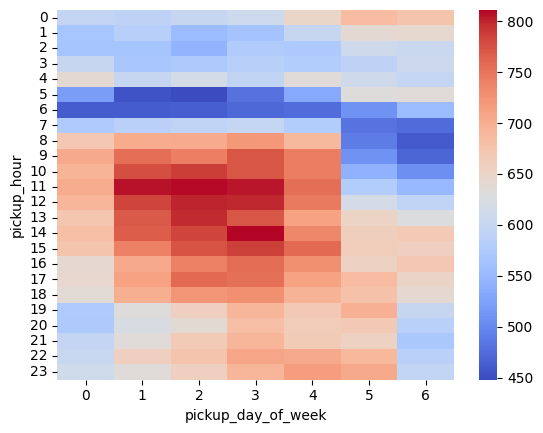

In [45]:
sns.heatmap(data=sum_tab, cmap = 'coolwarm')

Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.
Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


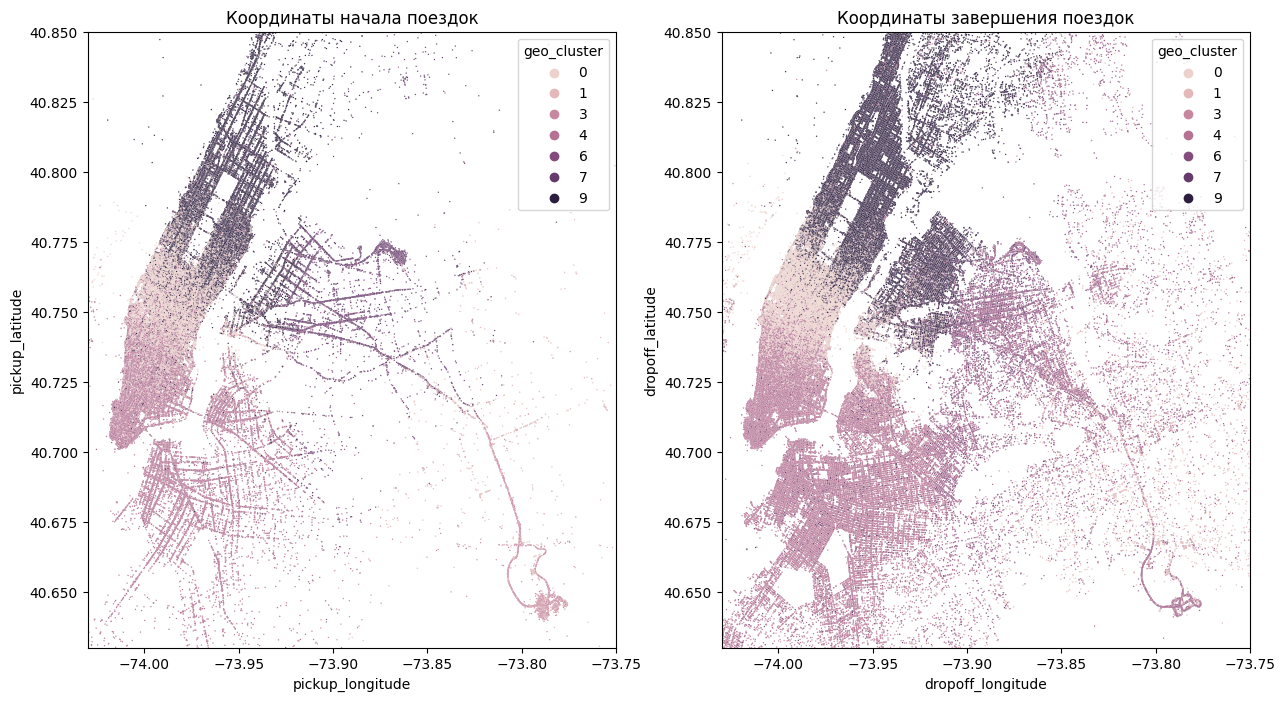

In [46]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# строим диаграммы рассеяния
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 8))

scatter_pickup = sns.scatterplot(
    data = taxi_data,
    x = 'pickup_longitude',
    y = 'pickup_latitude',
    hue = 'geo_cluster',
    s = 1,
    ax = axes[0])

scatter_pickup.set_title('Координаты начала поездок')
scatter_pickup.set_xlim(city_long_border)
scatter_pickup.set_ylim(city_lat_border)

scatter_dropoff = sns.scatterplot(
    data = taxi_data,
    x = 'dropoff_longitude',
    y = 'dropoff_latitude',
    hue = 'geo_cluster',
    s = 1,
    ax = axes[1])

scatter_dropoff.set_title('Координаты завершения поездок')
scatter_dropoff.set_xlim(city_long_border)
scatter_dropoff.set_ylim(city_lat_border);

3 кластера (из десяти) не попало на диаграммы, скорее всего они находится за границами Нью-Йорка

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [47]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [48]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [49]:
# Пункт А. Уникальными для каждой поездки и не несет полезной информации в определении ее продолжительности - это столбец-идентификатор id.
train_data.iloc[:,:1]

'''
Пункт Б.
Утечка данных (data leak) - это ситуация, в которой данные используемые для обучения модели,
содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.
'''

'''
Пункт В.
Признак dropoff_datetime - конечное время остановки счётчика поездки.
Начиная поездку, мы не знаем время её окончания.
'''

# Пункт Г.
train_data = train_data.drop(['id', 'dropoff_datetime'], axis = 1)
train_data.shape[1]

25

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [50]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [51]:
# Кодируем признак vendor_id
train_data.loc[train_data['vendor_id']==1, ['vendor_id']] = 0
train_data.loc[train_data['vendor_id']==2, ['vendor_id']] = 1

# Кодируем признак store_and_fwd_flag
train_data.loc[train_data['store_and_fwd_flag']=='N', ['store_and_fwd_flag']] = 0
train_data.loc[train_data['store_and_fwd_flag']=='Y', ['store_and_fwd_flag']] = 1

# Пункт А и Б
round(train_data['vendor_id'].mean(), 2), round(train_data['store_and_fwd_flag'].mean(), 3)

(0.53, 0.006)

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [52]:
OHE = preprocessing.OneHotEncoder(drop = 'first')

columns_for_ohe = ['pickup_day_of_week', 'geo_cluster', 'events']

ohe_data = OHE.fit_transform(
    train_data[columns_for_ohe]
).toarray() # результат переводим в массив

column_names = OHE.get_feature_names_out()

ohe_data = pd.DataFrame(ohe_data, columns = column_names)

print('Количество новых бинарных столбцов:', ohe_data.shape[1])

Количество новых бинарных столбцов: 18


Добавим полученную таблицу с закодированными признаками:

In [53]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_for_ohe, axis=1), ohe_data],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [54]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [55]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [56]:
selector = feature_selection.SelectKBest(
    score_func = feature_selection.f_regression,
    k = 25)

selector.fit(X_train, y_train_log)


best_25_features = selector.get_feature_names_out()
X_train = X_train[best_25_features]
X_valid = X_valid[best_25_features]
print('25 отобранных признаков:\n', best_25_features)

25 отобранных признаков:
 ['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_1'
 'pickup_day_of_week_2' 'pickup_day_of_week_3' 'pickup_day_of_week_4'
 'pickup_day_of_week_5' 'pickup_day_of_week_6' 'geo_cluster_1'
 'geo_cluster_3' 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [57]:
# инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# преобразовываем данные
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

print('Среднее первого предиктора из валидационной выборки:',
    round(np.mean(X_valid[:, 0]), 2))

Среднее первого предиктора из валидационной выборки: 0.54


In [58]:
# составляем DataFrame из массивов
X_train = pd.DataFrame(X_train, columns = best_25_features)
X_valid = pd.DataFrame(X_valid, columns = best_25_features)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [59]:
lin_reg_model = linear_model.LinearRegression()

lin_reg_model.fit(X_train, y_train_log)

y_train_pred = lin_reg_model.predict(X_train)
y_valid_pred = lin_reg_model.predict(X_valid)

# рассчитываем RMSLE
print('RMSE на тренировочной выборке:',
    round(np.sqrt(mse(y_train_log, y_train_pred)), 2))

print('RMSE на валидационной выборке:',
    round(np.sqrt(mse(y_valid_log, y_valid_pred)), 2))

RMSE на тренировочной выборке: 0.54
RMSE на валидационной выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


Сохраняем файлы о тренировочном и валидационном наборе данных с целью снижения траты оперативной памяти для возможности выполнения задания №5.2

In [48]:
np.save(f"/content/drive/MyDrive/Colab Notebooks/X_train", X_train)
np.save(f"/content/drive/MyDrive/Colab Notebooks/X_valid", X_valid)
np.save(f"/content/drive/MyDrive/Colab Notebooks/y_train_log", y_train_log)
np.save(f"/content/drive/MyDrive/Colab Notebooks/y_valid_log", y_valid_log)

Перезапускаем среду выполнения и считываем данные с google-диска

In [4]:
X_train = np.load(f"/content/drive/MyDrive/Colab Notebooks/X_train.npy")
X_valid = np.load(f"/content/drive/MyDrive/Colab Notebooks/X_valid.npy")
y_train_log = np.load(f"/content/drive/MyDrive/Colab Notebooks/y_train_log.npy")
y_valid_log = np.load(f"/content/drive/MyDrive/Colab Notebooks/y_valid_log.npy")

In [5]:
poly_feat = preprocessing.PolynomialFeatures(degree = 2, include_bias = False)
poly_feat.fit(X_train)

X_train_poly = poly_feat.transform(X_train)
X_valid_poly = poly_feat.transform(X_valid)


lin_reg_poly = linear_model.LinearRegression()
lin_reg_poly.fit(X_train_poly, y_train_log)
y_train_pred = lin_reg_poly.predict(X_train_poly)
y_valid_pred = lin_reg_poly.predict(X_valid_poly)

print('RMSE на тренировочной выборке:',
    round(np.sqrt(mse(y_train_log, y_train_pred)), 2))

print('RMSE на валидационной выборке:',
    round(np.sqrt(mse(y_valid_log, y_valid_pred)), 2))

RMSE на тренировочной выборке: 0.47
RMSE на валидационной выборке: 0.7


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [13]:
lin_reg_l2 = linear_model.Ridge(alpha = 1)

lin_reg_l2.fit(X_train_poly, y_train_log)

y_train_pred = lin_reg_l2.predict(X_train_poly)
y_valid_pred = lin_reg_l2.predict(X_valid_poly)

print('RMSE на тренировочной выборке:',
    round(np.sqrt(mse(y_train_log, y_train_pred)), 2))

print('RMSE на валидационной выборке:',
    round(np.sqrt(mse(y_valid_log, y_valid_pred)), 2))

RMSE на тренировочной выборке: 0.48
RMSE на валидационной выборке: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [60]:
# Пункт А
DTR = DecisionTreeRegressor(random_state = 42)
DTR.fit(X_train, y_train_log)

y_train_pred = DTR.predict(X_train)
y_valid_pred = DTR.predict(X_valid)

print('RMSE на тренировочной выборке:',
    round(np.sqrt(mse(y_train_log, y_train_pred)), 2))

print('RMSE на валидационной выборке:',
    round(np.sqrt(mse(y_valid_log, y_valid_pred)), 2))


'''
Пункт Б.
У модели наблюдаются признаки переобучения, т.к показатели RMSE на тренирововчной
и валидационной выборке сильно разнятся
'''

RMSE на тренировочной выборке: 0.0
RMSE на валидационной выборке: 0.57


'\nПункт Б.\nУ модели наблюдаются признаки переобучения, т.к показатели RMSE на тренирововчной\nи валидационной выборке сильно разнятся\n'

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


Best params: {'max_depth': 11}


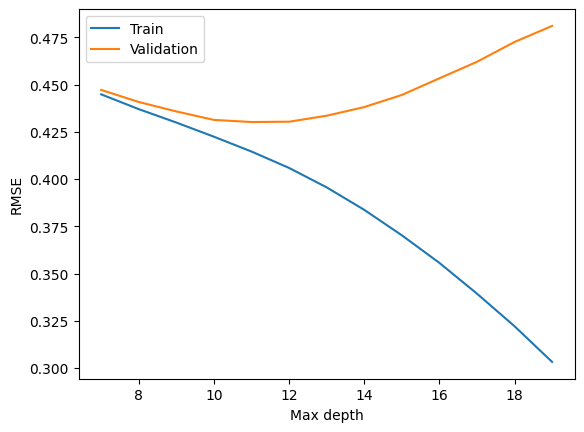

In [61]:
# Создаем модель решающего дерева
DTR_2 = DecisionTreeRegressor(random_state=42)

# Задаем диапазон значений глубины дерева
max_depths = range(7, 20)

# Создаем сетку параметров для GridSearch
param_grid = {'max_depth': max_depths}

# Инициализируем GridSearch с кросс-валидацией на 5 фолдах
grid_search = GridSearchCV(DTR_2, param_grid, cv=5, scoring='neg_mean_squared_error')

# Обучаем GridSearch на тренировочных данных
grid_search.fit(X_train, y_train_log)

# Получаем лучшую модель и ее параметры
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Выводим лучшие параметры модели
print(f'Best params: {best_params}')

# Получаем предсказания на тренировочной и валидационной выборках для каждого значения глубины дерева
train_scores = []
val_scores = []

for depth in max_depths:
    DTR_2.set_params(max_depth=depth)
    DTR_2.fit(X_train, y_train_log)
    train_pred = DTR_2.predict(X_train)
    val_pred = DTR_2.predict(X_valid)
    train_scores.append(np.sqrt(mse(y_train_log, train_pred)))
    val_scores.append(np.sqrt(mse(y_valid_log, val_pred)))

# Строим графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева
plt.plot(max_depths, train_scores, label='Train')
plt.plot(max_depths, val_scores, label='Validation')
plt.xlabel('Max depth')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [80]:
# Пункт А и Б
best_index = val_scores.index(min(val_scores))
print('Оптимальная глубина дерева решений:', max_depths[best_index])
print('RMSLE на тренировочной выборке:', round(train_scores[best_index], 2))
print('RMSLE на валидационной выборке:', round(val_scores[best_index], 2))

Оптимальная глубина дерева решений: 11
RMSLE на тренировочной выборке: 0.41
RMSLE на валидационной выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [62]:
RFR = RandomForestRegressor(
    n_estimators = 200,
    max_depth = 12,
    criterion = 'squared_error',
    min_samples_split = 20,
    random_state = 42,
    n_jobs = -1
)

RFR.fit(X_train, y_train_log)

y_train_pred = RFR.predict(X_train)
y_valid_pred = RFR.predict(X_valid)

print('RMSLE на тренировочной выборке:',
    round(np.sqrt(mse(y_train_log, y_train_pred)), 2))

print('RMSLE на валидационной выборке:',
    round(np.sqrt(mse(y_valid_log, y_valid_pred)), 2))

RMSLE на тренировочной выборке: 0.4
RMSLE на валидационной выборке: 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [63]:
GBR = GradientBoostingRegressor(
    learning_rate = 0.5,
    n_estimators = 100,
    max_depth = 6,
    min_samples_split = 30,
    random_state = 42)

GBR.fit(X_train, y_train_log)

y_train_pred = GBR.predict(X_train)
y_valid_pred = GBR.predict(X_valid)

print('RMSLE на тренировочной выборке:',
    round(np.sqrt(mse(y_train_log, y_train_pred)), 2))

print('RMSLE на валидационной выборке:',
    round(np.sqrt(mse(y_valid_log, y_valid_pred)), 2))

RMSLE на тренировочной выборке: 0.37
RMSLE на валидационной выборке: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


Градиентный бустинг над деревьями решений дал лучший результат на валидационной выборке:
RMSLE = 0.39

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


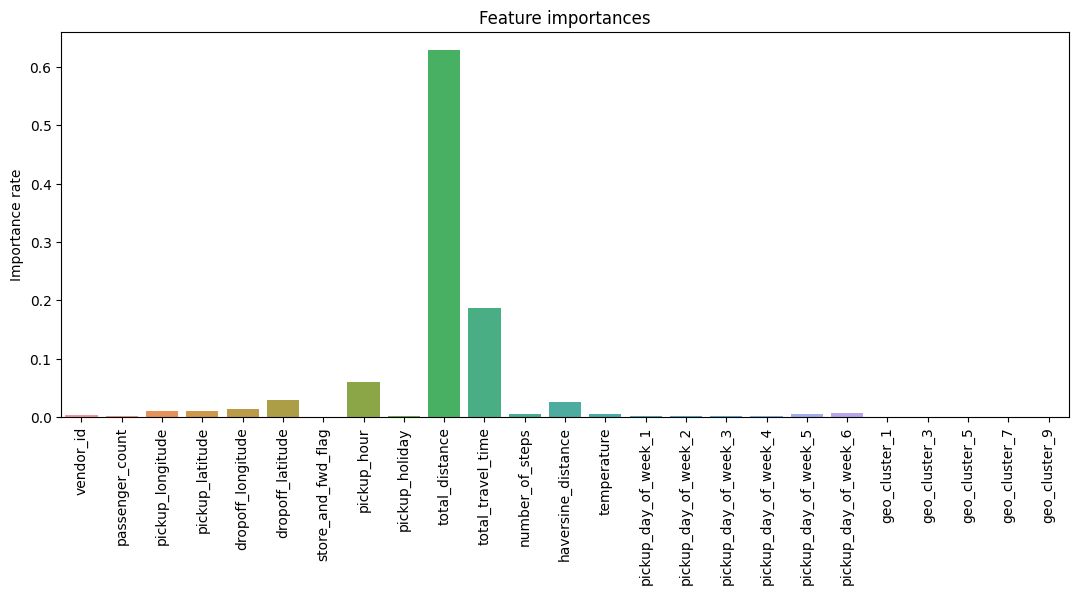

In [64]:
fig, ax = plt.subplots(figsize = (13, 5))
features = X_train.columns
importances = GBR.feature_importances_

# строим столбчатую диаграмму
sns.barplot(x = features, y = importances, ax = ax)
ax.set_title('Feature importances')
ax.set_ylabel('Importance rate')
ax.xaxis.set_tick_params(rotation = 90)

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [65]:
# переводим из логарифимического маштаба в изначальный
y_valid = np.exp(y_valid_log) - 1
y_valid_pred_exp = np.exp(y_valid_pred) - 1

# рассчитываем медианную абсолютную ошибку
mae_valid = mae(y_valid, y_valid_pred_exp)

print('MeAE на валидационной выборке:', round(mae_valid / 60, 1), 'мин')

MeAE на валидационной выборке: 1.8 мин


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [66]:
test_data = pd.read_csv("/content/drive/MyDrive/Проектный практикум/Project5_test_data.csv")
osrm_data_test = pd.read_csv("/content/drive/MyDrive/Проектный практикум/Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_cols(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = OHE.fit_transform(test_data[columns_for_ohe]).toarray()
column_names = OHE.get_feature_names_out(columns_for_ohe)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_for_ohe, axis=1), test_data_onehot],
    axis=1
)
X_test = test_data[best_25_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [68]:
y_test_pred_log = GBR.predict(X_test_scaled)

# переводим предсказания из логарифмического маштаба в истинный
y_test_predict = np.exp(y_test_pred_log) - 1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('/content/drive/MyDrive/Проектный практикум/submission_GBR.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [69]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


После чего модуль можно импортировать:

In [70]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [73]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=best_25_features)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=best_25_features)
dtest = xgb.DMatrix(X_test, feature_names=best_25_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [74]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42222	valid-rmse:5.42195
[10]	train-rmse:1.93570	valid-rmse:1.93568
[20]	train-rmse:0.78554	valid-rmse:0.78636
[30]	train-rmse:0.47951	valid-rmse:0.48155
[40]	train-rmse:0.42185	valid-rmse:0.42460
[50]	train-rmse:0.40989	valid-rmse:0.41310
[60]	train-rmse:0.40505	valid-rmse:0.40877
[70]	train-rmse:0.40116	valid-rmse:0.40524
[80]	train-rmse:0.39927	valid-rmse:0.40366
[90]	train-rmse:0.39777	valid-rmse:0.40257
[100]	train-rmse:0.39563	valid-rmse:0.40071
[110]	train-rmse:0.39439	valid-rmse:0.39970
[120]	train-rmse:0.39358	valid-rmse:0.39911
[130]	train-rmse:0.39259	valid-rmse:0.39838
[140]	train-rmse:0.39160	valid-rmse:0.39779
[150]	train-rmse:0.39048	valid-rmse:0.39699
[160]	train-rmse:0.38983	valid-rmse:0.39661
[170]	train-rmse:0.38900	valid-rmse:0.39602
[180]	train-rmse:0.38819	valid-rmse:0.39555
[190]	train-rmse:0.38706	valid-rmse:0.39485
[200]	train-rmse:0.38625	valid-rmse:0.39430
[210]	train-rmse:0.38552	valid-rmse:0.39397
[220]	train-rmse:0.38475	valid-rmse:0.39360

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [75]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39167


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

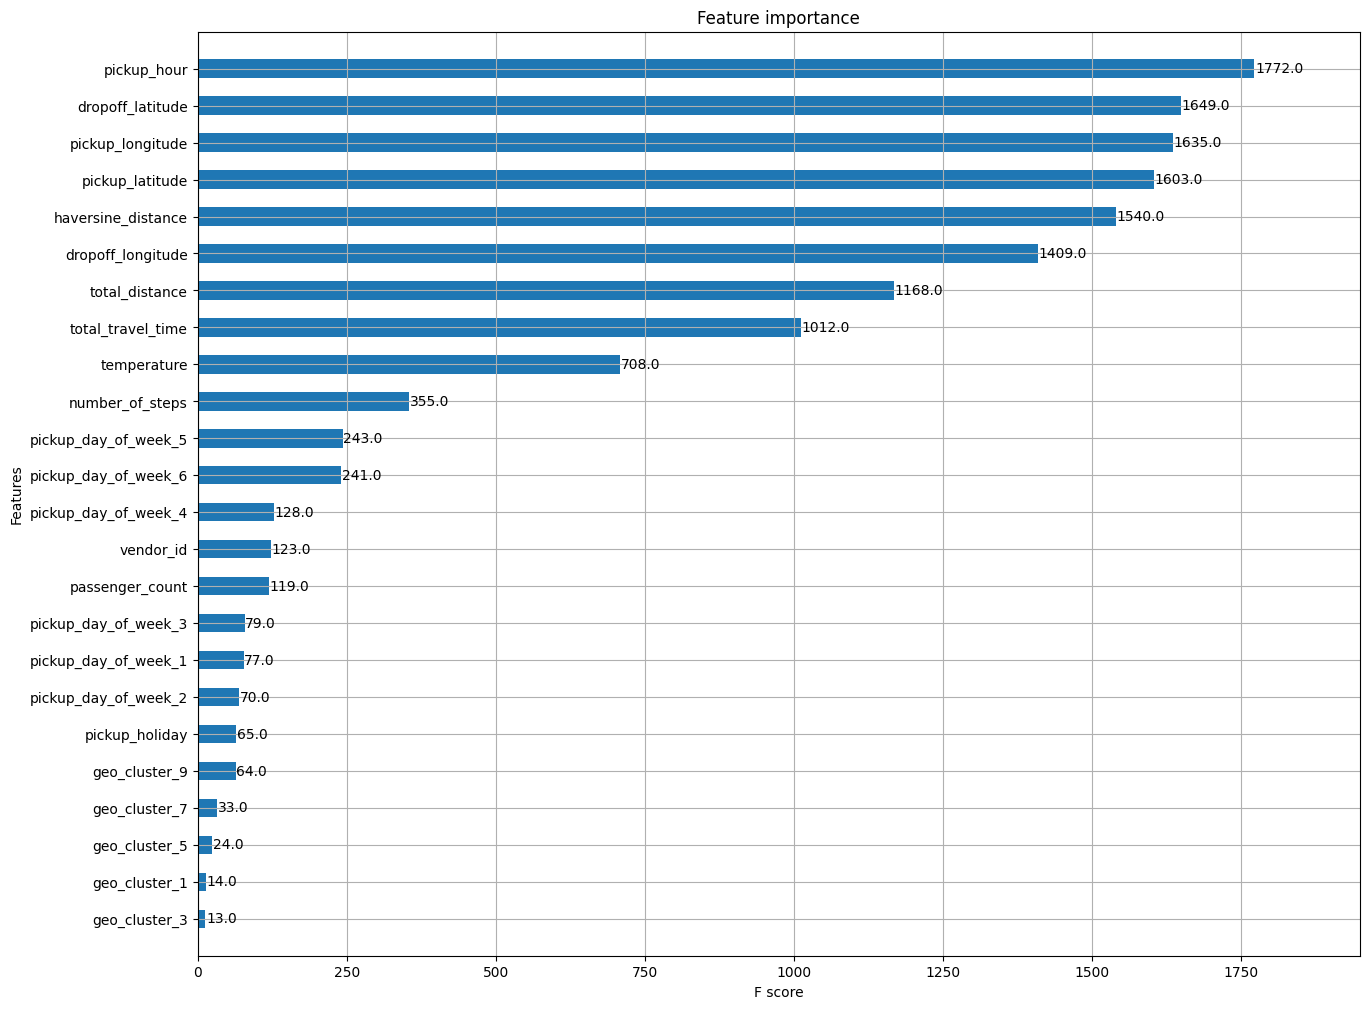

In [77]:
fig, ax = plt.subplots(figsize = (15,12))
xgb.plot_importance(model, ax = ax, height=0.5)